<a href="https://colab.research.google.com/github/scarabinoalbano/07MIAR_04_A_2025-26_Redes-Neuronales-y-Deep-Learning/blob/main/07MIAR_Proyecto_Programacion_Grupo8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de Programación "*Deep Vision in classification tasks*"

## Integrantes:
 - Adrián Ortiz Martínez
 - Albano Andrés Scarabino Guissani
 - Gonzalo Rosas Ortiz
 - Alumno 4

In [ ]:
#Importamos librerías de propóstio general
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

## Carga y Análisis de datos

Como se ha visto a lo largo de este curso, el correcto diseño de una red neuronal se base principalmente en un buen análisis de datos, esto con el objetivo de conocer la calidad de la información y definir las acciones posteriores.

In [ ]:
# Montamos conexión a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Analizamos el DataFrame
df_path = '/content/drive/MyDrive/datase_set/train.csv'
df = pd.read_csv(df_path,sep='|')
display(df.groupby('folder')['folder'].count().sort_values(ascending=False))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datase_set/train.csv'

De la tabla anterior se procede a resltar los siguientes puntos:
- Se cuenta con un dataset que consta de 4750 imágenes, revisando el estado del arte, podríamos considerar nuestro dataset como mediano.
- Se observa un desbalanceo importante entre clases, reportando un número de 654 en la clase mayoritaria y 221 en la clase minoritaría.

Los puntos anteriores son de suma importancia porque nos dan un indicio de los pasos a realizar previos a la fase de entrenamiento, dichos pasos se detallan en la siguiente sección.

## Preprocesamiento de Imagenes

En la sección anterior se mencionó que debido al númeor de muestras en el dataset, este podría ser considerado como mediano,consultando el estado del arte, se puede resaltar las siguientes tareas previo al entrenamiento del modelo:

1. Data Augmentation
  - Rotación
  - Traslación
  - Flip
  - Cambio de brillo
2. Escala de Imágenes
3. Normalización

Por lo anterior, procedemos a implementar dichas tareas en las funciones que se muestran a continuación:

In [ ]:
def data_augmentation(image):

    img = tf.image.random_flip_left_right(image)
    img = tf.cond(tf.random.uniform([]) < 0.3, lambda : tf.image.random_flip_up_down(img), lambda : img)
    img = tf.cond(tf.random.uniform([]) < 0.3, lambda : tf.image.random_brightness(img,max_delta=0.2), lambda : img)
    img = tf.cond(tf.random.uniform([]) < 0.4, lambda : tf.image.random_contrast(img,lower=0.8,upper=1.2), lambda : img)
    img = tf.image.rot90(img,k = np.random.randint(1,4))

    return img

# Función que convierte la función de carga a tf.function para optimizarla

def tf_load_image(path, label,is_training=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32)

    if is_training : img = data_augmentation(img)

    img = tf.image.resize(img,size=[224,224],method='lanczos3')
    img = img / 255.0
    label = tf.one_hot(label,depth=12)
    return img, label

## 1. Pipeline para el de datos

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

El primer paso es realizar one-hot encoding, este proceso se hace debido a las siguientes razones:
1. El dataset no contiene ningún archivo .csv que nos indique las clases de salida.
2. El dataset está organizado en carpetas y dentro de ellas, encontramos las imágenes.

Es por lo anterior que, tomamos como salida el nombre de cada folder que conforma el dataset y lo transformamos en una variables cuantitativa que el modelo pueda usar.

In [ ]:
extract_path = '/content/drive/MyDrive/datase_set/'
# Realizamos proceso de one-hot encoding para discretizar las clases del dataset
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['folder'])
df['path'] = df.apply(lambda row : os.path.join(extract_path,'train',row['folder'],row['file_name']),axis=1)
display(df)

,file_name,folder,length,width,label,path
0,0050f38b3.png,Black-grass,196,196,0,/content/drive/MyDrive/datase_set/train/Black-...
1,0183fdf68.png,Black-grass,388,388,0,/content/drive/MyDrive/datase_set/train/Black-...
2,0260cffa8.png,Black-grass,886,886,0,/content/drive/MyDrive/datase_set/train/Black-...
3,05eedce4d.png,Black-grass,117,117,0,/content/drive/MyDrive/datase_set/train/Black-...
4,075d004bc.png,Black-grass,471,471,0,/content/drive/MyDrive/datase_set/train/Black-...
...,...,...,...,...,...,...
4745,fc293eacb.png,Sugar beet,548,548,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4746,fc441208c.png,Sugar beet,182,182,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4747,fed9406b2.png,Sugar beet,431,431,11,/content/drive/MyDrive/datase_set/train/Sugar ...
4748,fef5e7066.png,Sugar beet,1005,1005,11,/content/drive/MyDrive/datase_set/train/Sugar ...


Procedemos a realizar una partición externa 80-20% estratificada, asegurandonos de que los conjuntos de entrenamiento y validación conserven la misma proporción que en el dataset original.

In [ ]:
#Panteamos una validación Hold-Out externa
X_train,X_test,y_train,y_test = train_test_split(df['path'],df['label'],test_size=0.2,stratify=df['label'],random_state=42)

#Creamos Test de validación
X_dev_train, X_val, y_dev_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Una vez realizada la partición externa, procedemos a definir el pipeline para el pre-procesamiento del dataset, lo que se busca con este pipeline es proveer al modelo con un dataset variado en cada época y lograr así, una buena generalización sobre el dataset.

In [ ]:
#Creamos pipeline para lectura de datos
train_dataset = tf.data.Dataset.from_tensor_slices((X_dev_train.values,y_dev_train.values))
train_dataset = train_dataset.map(lambda x,y : tf_load_image(x,y,is_training=True), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values,y_val.values))
val_dataset = val_dataset.map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values,y_test.values))
test_dataset = test_dataset.map(tf_load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## 2. Diseño de Modelo desde Cero

Para el modelo desde cero se propone una red neuronal con las siguientes características:


1.   3 bloques para la obtención de características principales de tipo: CONV+BN+DP
2.   1 Capa de Global AvergaPooling para "apilar" las imagenes resultantes despues del filtrado.
3. 2 bloques de tipo Dense+DP para la reduccir las dimensiones de nuestro proceso de análisis y evitar overfitting.



In [ ]:
#Importamos librerías para diseñar la red neuronal
from tensorflow.keras import layers,models,regularizers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:

def image_classificator():

    input_layer = layers.Input(shape=(224,224,3)) # Definimos capa de entrada

    '''Primer bloque de convolución, iniciamos con 16 filtros, kernel de 3x3 y strides de 1 para captar la mayor
    de la imagen, al termino de este bloque, reducimos la imagen a la mitad, aplicamos un dropout al 0.2
    '''
    x1 = layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(input_layer)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPool2D(pool_size=2)(x1)
    x1 = layers.Dropout(rate=0.2)(x1)

    '''
    En el segundo bloque iniciamos con 32 filtros
    '''
    x2 = layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPool2D(pool_size=2)(x2)
    x2 = layers.Dropout(rate=0.2)(x2)

    '''
    En el tercer bloque iniciamos con 64 filtros
    '''
    x3 = layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.MaxPool2D(pool_size=2)(x3)


    #Aplanamos el resultado de la capa anterior
    x4 = layers.GlobalAveragePooling2D()(x3)

    #Iniciamos la etapa de deconstrucción, aquí aplicaremos un droput decremental

    x5 = layers.Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x4)
    x5 = layers.Dropout(rate=0.2)(x5)

    x6 = layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.00001))(x5)
    x6 = layers.Dropout(rate=0.2)(x6)

    x7 = layers.Dense(12)(x6) #unidad de 12 porque son 12 clases a predecir

    #Generamos salida
    output_layer = layers.Activation('softmax')(x7)

    return models.Model(inputs=input_layer,outputs=output_layer)

### 2.1 Entrenamiento de Modelo

In [ ]:
#Importamos funciones de Callback y métricas para el entrenamiento
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

Declaramos métricas:

In [ ]:
metricas=[
  metrics.Precision(name='precision'),
  metrics.Recall(name='recall'),
  metrics.AUC(name='auc'),
  metrics.F1Score( average='macro', name='f1_macro'),
  'accuracy'
    ]

Declaramos callbacks para monitorizar el entrenamiento:

In [ ]:
#Callback para guardar mejor versión del modelo durante el entrenamiento
checkpoint_sm = ModelCheckpoint(
    filepath='scratch_model2.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

#Callback para detener el entrenamiento si el accuracy no mejora tras 7 épocas consecutivas
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=7,
                               restore_best_weights=True)

De la sección de Carga y Análisis de datos se observa que nuestro dataset está desbalanceado, lo cual, podría afectar negativamente el entrenamiento y rendimiento final del modelo, es por ello que, como último paso antes de proceder al entrenamiento del modelo se realizará un balanceo de clases, esto nos ayudara a asegurarnos de que el modelo ajuste los parámetros en cada época en torno a la proporción de muestras por clase.

In [ ]:
y_classes = np.unique(df['label'],return_counts=False)
weights = compute_class_weight(class_weight='balanced',classes=y_classes,y=df['label'])
class_weight_dict = {}
for i in range(0,len(y_classes)):
    class_weight_dict[int(y_classes[i])] = float(np.round(weights[i],3))
print(class_weight_dict)

{0: 1.505, 1: 1.015, 2: 1.379, 3: 0.648, 4: 1.791, 5: 0.833, 6: 0.605, 7: 1.791, 8: 0.767, 9: 1.714, 10: 0.798, 11: 1.028}


Nos aseguramos de realizar el entrenamiento meidante el uso debGPU para ahorrar tiempo en esta fase

In [ ]:
from tensorflow.python.client import device_lib
!nvidia-smi

print(tf.test.gpu_device_name())
device_lib.list_local_devices()

Sun Nov  9 17:36:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             33W /   70W |    2164MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9460555999247991517
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 626593119226938916
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

### 2.2 Validación de Resultados

In [ ]:
#Función para gráficar Historico de entrenamiento

def plot_training(history_training,model_name):
  fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
  axes[0].plot(history_training.history['loss'], label='Entrenamiento')
  axes[0].plot(history_training.history['val_loss'], label='Validación')
  axes[0].set_title(f"Pérdida durante el entrenamiento - {model_name}")
  axes[0].set_xlabel('Épocas')
  axes[0].set_ylabel('Precisión')
  axes[0].legend()

  axes[1].plot(history_training.history['accuracy'], label='Entrenamiento')
  axes[1].plot(history_training.history['val_accuracy'], label='Validación')
  axes[1].set_title(f"Precisión durante el entrenamiento - {model_name}")
  axes[1].set_xlabel('Épocas')
  axes[1].set_ylabel('Precisión')
  axes[1].legend()


In [ ]:
# plot_training()  #Descomentar cuando se tenga el modelo creado desde 0

## 3. Transfer Learning y Fine Tunning

### 3.1 Selección de Modelos

Para este apartado, procedemos a visitar la documentación de ***keras.applications*** y extraemos la información más relevante de los modelos a elegir, los resultados se muestran a continuación:

| Modelo | # Parámetros | Profundidad |
| -  | - | - |
| Xception | 22.9 M | 81  |
| VGG16 | 138.4 M | 16  |
| VGG19 | 143.7 M | 19  |
| ResNet50 | 25.6 M | 107  |
| InceptionV3 | 23.9 M | 189  |
| InceptionResNetV2 | 55.9 M | 449  |
| MobileNetV2 | 3.5 M | 105  |
| DenseNet1211 | 8.1 M | 242  |

De la tabla anterior y retomando de la sección de Análisis de Datos, se observa que la mayoría de modelos preentrenados son demasiado complejos para la tarea de clasificar 12 tipos de plantas, lo cual, nos llevaría a problemas de over y underfitting durante el entrenamiento, es por esto que, para efectos de esta práctica los modelos seleccionados son las siguientes:

- MobileNetV2
- DenseNet121

In [ ]:
#Importamos Modelos Entrenados
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121

### 3.2 Transfer Learning

Dado que los modelos seleccionados no parecen tener una arquitectura muy compleja para nuestra tarea de clasificación, la primera estrategia consiste en hacer transfer learning donde haremos uso del modelo en su totalidad y solo añadirémos unas capas a la salida para adaptarlo a la clasificación de 12 clases.

In [ ]:
# Instanciamos modelos omitiendo la salida y usando los pesos del dataset ImageNet
mn_base = MobileNetV2(weights="imagenet",classes=12,include_top=False,input_shape=(224,224,3))
denset_base = DenseNet121(weights="imagenet",classes=12,include_top=False,input_shape=(224,224,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Congelamos los modelos base para evitar actualizar sus pesos durante el entrenamiento:

In [ ]:
#Declaramos la base de ambos modelos como no entrenables puesto que haremos transfer learning
mn_base.trainable = False
denset_base.trainable = False

Añadimos capas finales al modelo MobileNetV2

In [ ]:
x_mn = mn_base.output
x_mn = layers.GlobalAveragePooling2D()(x_mn)
x_mn = layers.Dropout(rate=0.3)(x_mn)
x_mn = layers.Dense(12)(x_mn)

#Generamos salida
output_layer_mn = layers.Activation('softmax')(x_mn)
mn_model = Model(inputs=mn_base.input,outputs=output_layer_mn)

#Mostramos Summary
mn_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Repetimos proceso para DenseNet121

In [ ]:
x_dn = denset_base.output
x_dn = layers.GlobalAveragePooling2D()(x_dn)
x_dn = layers.Dropout(rate=0.3)(x_dn)

x_dn = layers.Dense(12)(x_dn) #unidad de 12 porque son 12 clases a predecir

#Generamos salida
output_layer_dn = layers.Activation('softmax')(x_dn)
dn_model = Model(inputs=denset_base.input,outputs=output_layer_dn)

#Mostramos Summary
dn_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,049,804 (26.89 MB)

 Trainable params: 12,300 (48.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

#### 3.2.1 Entrenamiento

In [ ]:
#Compilamos Modelos

with tf.device('/GPU:0'):
  optimizer = Adam(learning_rate=0.0001)
  mn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=metricas)

In [ ]:
#Compilamos Modelos

with tf.device('/GPU:0'):
  optimizer = Adam(learning_rate=0.0001)
  dn_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=metricas)

In [ ]:
history_mn = mn_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 74s 560ms/step - accuracy: 0.4394 - auc: 0.8712 - f1_macro: 0.4273 - loss: 1.6499 - precision: 0.6581 - recall: 0.1760 - val_accuracy: 0.5645 - val_auc: 0.9125 - val_f1_macro: 0.5530 - val_loss: 1.4237 - val_precision: 0.8516 - val_recall: 0.2039
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 86s 677ms/step - accuracy: 0.4547 - auc: 0.8935 - f1_macro: 0.4481 - loss: 1.5053 - precision: 0.7013 - recall: 0.2069 - val_accuracy: 0.5803 - val_auc: 0.9198 - val_f1_macro: 0.5651 - val_loss: 1.3671 - val_precision: 0.8424 - val_recall: 0.2250
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 131s 582ms/step - accuracy: 0.5099 - auc: 0.9042 - f1_macro: 0.5025 - loss: 1.4100 - precision: 0.7029 - recall: 0.2720 - val_accuracy: 0.6211 - val_auc: 0.9290 - val_f1_macro: 0.6100 - val_loss: 1.2943 - val_precision: 0.8627 - val_recall: 0.2645
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.5327 - auc: 0.9139 - f1_macro: 0.5170 - loss: 1.3609 - precision: 0.7189 - re

In [ ]:
history_dn = dn_model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 134s 802ms/step - accuracy: 0.0657 - auc: 0.7441 - f1_macro: 0.3554 - loss: 2.9197 - precision: 0.8135 - recall: 0.2802 - val_accuracy: 0.0829 - val_auc: 0.5436 - val_f1_macro: 0.0722 - val_loss: 2.5424 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 73s 573ms/step - accuracy: 0.0966 - auc: 0.5406 - f1_macro: 0.0952 - loss: 2.6516 - precision: 0.1556 - recall: 0.0023 - val_accuracy: 0.1408 - val_auc: 0.6566 - val_f1_macro: 0.1434 - val_loss: 2.3611 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 71s 561ms/step - accuracy: 0.1498 - auc: 0.6214 - f1_macro: 0.1505 - loss: 2.4409 - precision: 0.5037 - recall: 0.0074 - val_accuracy: 0.2368 - val_auc: 0.7379 - val_f1_macro: 0.2304 - val_loss: 2.2164 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 70s 554ms/step - accuracy: 0.1966 - auc: 0.6729 - f1_macro: 0.1946 - loss: 2.3106 

#### 3.2.2 Validación de Resultados

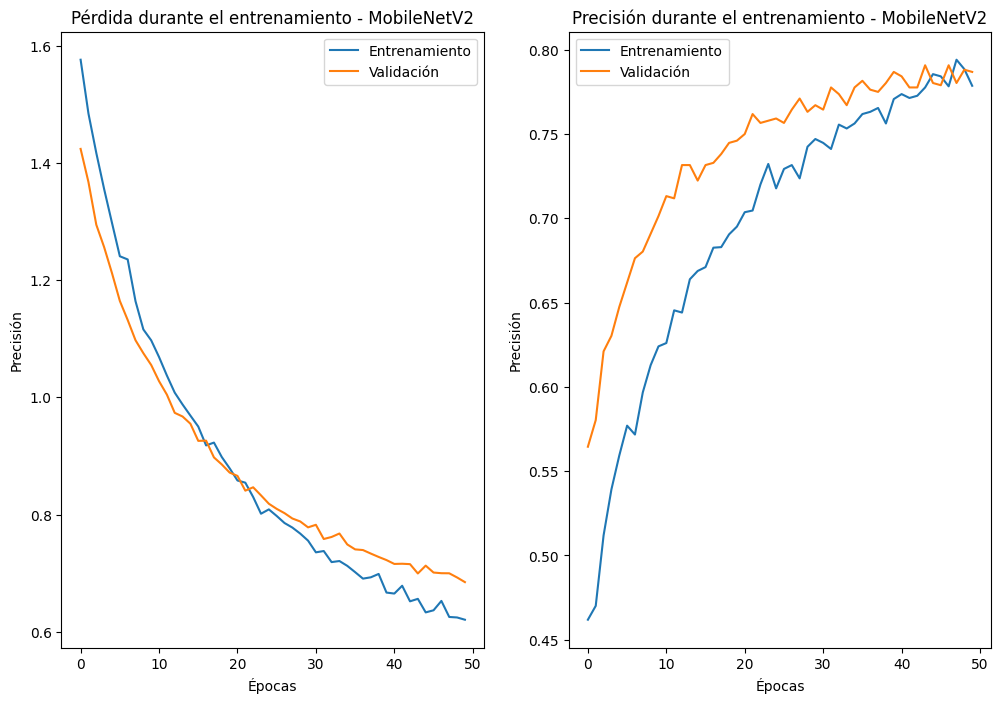

In [ ]:
plot_training(history_mn,'MobileNetV2')

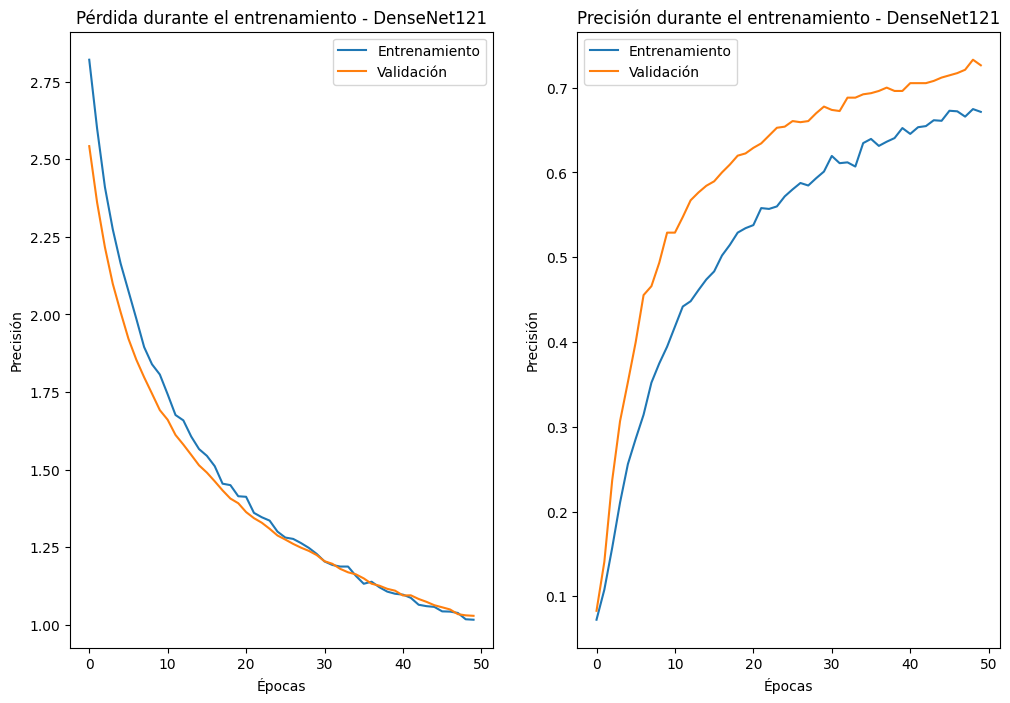

In [ ]:
plot_training(history_dn,'DenseNet121')

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
mn_test = mn_model.predict(test_dataset)


30/30 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step


In [ ]:
dn_test = dn_model.predict(test_dataset)

30/30 ━━━━━━━━━━━━━━━━━━━━ 39s 854ms/step


### 3.3 Fine Tunning



#### 3.3.1 Entrenamiento

#### 3.3.2 Validación de Resultados

## 4. Comparativa: Modelo desde cero vs Modelos Pre-entrenado

Para está sección, usaremos como métrica de decisión la matriz de confusión para determinar que modelo fue el mejor duanrte el desarrollo de la práctica. Iniciamos con el modelo entrenado desde 0:

Seguimos con los modelos pre-entrenados + transfer learning:

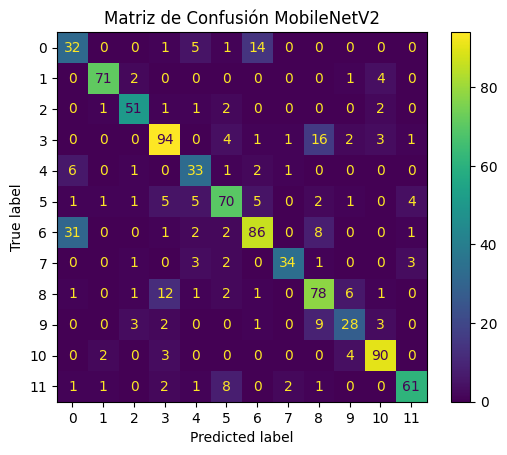

In [ ]:
y_pred_mn = np.argmax(mn_test, axis=1)
cf_mn = confusion_matrix(y_test,y_pred_mn)

mn_disp = ConfusionMatrixDisplay(cf_mn)
mn_disp.plot()
plt.title('Matriz de Confusión MobileNetV2')
plt.show()

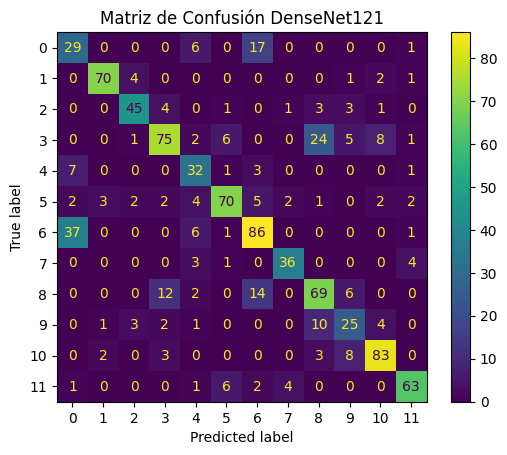

In [ ]:
y_pred_dn = np.argmax(dn_test, axis=1)
cf_dn = confusion_matrix(y_test,y_pred_dn)

dn_disp = ConfusionMatrixDisplay(cf_dn)
dn_disp.plot()
plt.title('Matriz de Confusión DenseNet121')
plt.show()

Finalmente agregamos los modelos pre-entrenados con fine tunning:

De las gráficas anterios se observa que el modelo con mejor desempeño y, el cual, se podría poner en producción es:  #Insertar modelo ganador.

## 5. Apéndice de Experimentación

## 6. Bibilografía

- [1] keras.applications: https://keras.io/api/applications/

- [2] A snapshot of image pre-processing for convolutional neural networks: case study of MNIST
- [3] Master These 5 Essential Tips for Preprocessing Image Data
- [4] An empirical study of preprocessing techniques with convolutional neural networks for accurate detection of chronic ocular diseases using fundus images